In [23]:
# 150x200
# Fibrosis level 0 vs 4
# drop 0

In [1]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import zipfile
import os
import shutil
import random

In [2]:
data = pd.read_csv("data.csv")
data.Fibrosis = data.Fibrosis.replace('-', np.NaN)
data.Equipment.value_counts()

IU22        101
LOGIQE9      99
iu22         78
EUB-7500     70
eub-7500     45
S2000        28
s2000         5
Name: Equipment, dtype: int64

In [3]:
# to upper character

# data['Equipment'] = data['Equipment'].apply(lambda x: x.upper())

In [4]:
data['Equipment'] = 'M'

In [5]:
def sort_by_equipment(equipment):
    return data[(data['Equipment'] == equipment)]['Fibrosis'].value_counts()

In [6]:
data.Fibrosis = pd.to_numeric(data.Fibrosis)

In [7]:
# divide the data by Equipment

def fill_zero(f):
    for i in range(len(f)):
        f[i] = f[i].zfill(4)
    
    return f

def sort_by_tool(equipment):
    f_neg = data[(data['Fibrosis']==0) & (data['Equipment']==equipment.upper())].number.astype(str).tolist()
    f_pos = data[(data['Fibrosis']==4) & (data['Equipment']==equipment.upper())].number.astype(str).tolist()
    ################ change the Fibrosis level from here #####################
    
    
    
    # fill the zeros (for foloder name)
    f_neg = fill_zero(f_neg)
    f_pos = fill_zero(f_pos)
    
    return f_neg, f_pos


def move_to_tmp(local_zip, equipment, base_loc):
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/tmp/Liver_'+equipment)
    zip_ref.close()

def make_folder(base_loc):
    try:
        os.mkdir(base_loc)
        os.mkdir(base_loc+'/training')
        os.mkdir(base_loc+'/training/f0')
        os.mkdir(base_loc+'/training/f1')
        os.mkdir(base_loc+'/testing')
        os.mkdir(base_loc+'/testing/f0')
        os.mkdir(base_loc+'/testing/f1')

    except OSError:
        pass

def move_to_folder(f_, folder_loc, split, base_loc):
    split = int(len(f_)*(1-split))
    
    f_train = f_[:split]
    f_test = f_[split:]
    
    print(folder_loc,':',len(f_train))
    print(folder_loc,':',len(f_test))
    
    new_name = 0
    for folder_name in f_train:
        for root, subdirs, files in os.walk(base_loc+'/'+folder_name):
            for f in files:
                # file_name change
                try:
                    file_to_change = os.path.join(root, f)
                    dst = str(new_name)+'.tif'
                    dst = os.path.join(root, dst)
                    # print(file_to_change, new_name)

                    os.rename(file_to_change, dst)
                    new_name += 1
                    tmp = base_loc+'/training/'+folder_loc
                    # file move
                    shutil.move(dst, tmp)
                except:
                    print('error')
    
    new_name = 0                    
    for folder_name in f_test:
        for root, subdirs, files in os.walk(base_loc+'/'+folder_name):
            for f in files:
                # file_name change
                try:
                    file_to_change = os.path.join(root, f)
                    dst = str(new_name)+'.tif'
                    # print(file_to_change, new_name)

                    dst = os.path.join(root, dst)
                    os.rename(file_to_change, dst)
                    new_name += 1
                    tmp = base_loc+'/testing/'+folder_loc
                    # file move
                    shutil.move(dst, tmp)
                except:
                    print('error')

In [8]:
def train_test_split(equipment, local_zip, split_size):
    equipment = equipment.upper()
    f_false, f_true = sort_by_tool(equipment)
    
    random.shuffle(f_false)
    random.shuffle(f_true)
    
    make_folder(base_loc)
    move_to_tmp(local_zip, equipment, base_loc)
    
    move_to_folder(f_false, 'f0', 0.2, base_loc)
    move_to_folder(f_true, 'f1', 0.2, base_loc)

In [15]:
def ImageGenerator(base_loc):
    TRAINING_DIR = base_loc+'/training'
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True, 
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       fill_mode='nearest',
                                      )

    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                       batch_size=8,
                                                       class_mode='binary',
                                                       target_size=(150,200),                                                        
                                                       color_mode='grayscale') # target_size = (height, width)

    TESTING_DIR = base_loc+'/testing'
    test_datagen = ImageDataGenerator(rescale = 1.0/255.)

    test_generator = train_datagen.flow_from_directory(TESTING_DIR,
                                                       batch_size=16,
                                                       class_mode='binary',
                                                       target_size=(150,200), 
                                                       color_mode='grayscale')
    
    return train_generator, test_generator

In [10]:
# change
equipment = 'M' 
local_zip = '../../../Data/150_200.zip'
base_loc = '/tmp/Liver_' + equipment

In [11]:
train_test_split(equipment, local_zip, 0.2)

f0 : 116
f0 : 30
f1 : 118
f1 : 30


In [12]:
# training

# error files:
# 1881/mask/1881-0006.tif
# 1813/mask/1813-0002.tif
# 2103/mask/2013-0001.tif

In [13]:
print("Training Fibrosis 0:", len(os.listdir(base_loc+'/training/f0')))
print("Testing Fibrosis 0:", len(os.listdir(base_loc+'/testing/f0')))
print("-"*25)
print("Training Fibrosis 1:", len(os.listdir(base_loc+'/training/f1')))
print("Testing Fibrosis 1:", len(os.listdir(base_loc+'/testing/f1')))

Training Fibrosis 0: 875
Testing Fibrosis 0: 234
-------------------------
Training Fibrosis 1: 723
Testing Fibrosis 1: 188


In [16]:
train_generator, test_generator = ImageGenerator(base_loc)

Found 1598 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Simple Res Model

In [18]:
from tensorflow.keras.layers import Layer

In [19]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, input_tensor):
        X = self.conv1(input_tensor)
        X = self.bn1(X)
        X = self.act(X)
        
        X = self.conv2(X)
        X = self.bn2(X)
        
        X = self.add([X, input_tensor])
        X = self.act(X)
        return X
    
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        
        self.flatten = tf.keras.layers.Flatten()
        self.drop = tf.keras.layers.Dropout(0.2)
        self.dense_1 = tf.keras.layers.Dense(1024, activation='sigmoid')
        self.dense_2 = tf.keras.layers.Dense(512, activation='sigmoid')
        self.classifier = tf.keras.layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)
        x = self.global_pool(x)
        
        x = self.flatten(x)
        # x = self.drop(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        return self.classifier(x)

In [20]:
resnet = ResNet(1)

In [21]:
resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])

In [23]:
history = resnet.fit(train_generator,
           epochs=100,
           validation_data=test_generator)

Epoch 1/100
200/200 [==============================] - 11s 56ms/step - loss: 0.6500 - accuracy: 0.6158 - val_loss: 0.6150 - val_accuracy: 0.6754
Epoch 2/100
200/200 [==============================] - 11s 56ms/step - loss: 0.6270 - accuracy: 0.6446 - val_loss: 0.6719 - val_accuracy: 0.5711
Epoch 3/100
200/200 [==============================] - 11s 57ms/step - loss: 0.6250 - accuracy: 0.6483 - val_loss: 0.6383 - val_accuracy: 0.6256
Epoch 4/100
200/200 [==============================] - 11s 56ms/step - loss: 0.6093 - accuracy: 0.6696 - val_loss: 0.6699 - val_accuracy: 0.6161
Epoch 5/100
200/200 [==============================] - 11s 57ms/step - loss: 0.6000 - accuracy: 0.6790 - val_loss: 0.6374 - val_accuracy: 0.6327
Epoch 6/100
200/200 [==============================] - 11s 57ms/step - loss: 0.6324 - accuracy: 0.6427 - val_loss: 0.6728 - val_accuracy: 0.6019
Epoch 7/100
200/200 [==============================] - 12s 58ms/step - loss: 0.6044 - accuracy: 0.6721 - val_loss: 0.5877 - val_ac

200/200 [==============================] - 11s 57ms/step - loss: 0.4536 - accuracy: 0.7910 - val_loss: 0.4646 - val_accuracy: 0.7749
Epoch 58/100
200/200 [==============================] - 11s 57ms/step - loss: 0.4646 - accuracy: 0.7891 - val_loss: 0.6573 - val_accuracy: 0.6493
Epoch 59/100
200/200 [==============================] - 11s 57ms/step - loss: 0.4447 - accuracy: 0.7885 - val_loss: 0.4776 - val_accuracy: 0.7796
Epoch 60/100
200/200 [==============================] - 11s 57ms/step - loss: 0.4495 - accuracy: 0.7847 - val_loss: 0.4003 - val_accuracy: 0.8175
Epoch 61/100
200/200 [==============================] - 11s 57ms/step - loss: 0.4430 - accuracy: 0.7897 - val_loss: 0.5740 - val_accuracy: 0.7370
Epoch 62/100
200/200 [==============================] - 11s 57ms/step - loss: 0.4542 - accuracy: 0.7879 - val_loss: 0.4638 - val_accuracy: 0.8033
Epoch 63/100
200/200 [==============================] - 11s 57ms/step - loss: 0.4382 - accuracy: 0.7960 - val_loss: 0.4094 - val_accuracy

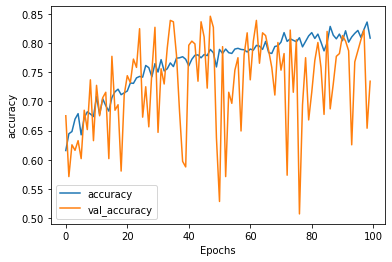

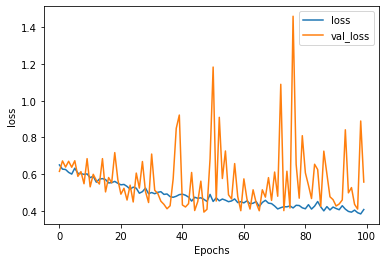

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [26]:
history2 = resnet.fit(train_generator,
           epochs=200,
           validation_data=test_generator)

Epoch 1/200
200/200 [==============================] - 12s 58ms/step - loss: 0.4170 - accuracy: 0.8004 - val_loss: 0.4859 - val_accuracy: 0.7915
Epoch 2/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3847 - accuracy: 0.8342 - val_loss: 0.4536 - val_accuracy: 0.7962
Epoch 3/200
200/200 [==============================] - 11s 57ms/step - loss: 0.4285 - accuracy: 0.8066 - val_loss: 0.4432 - val_accuracy: 0.8033
Epoch 4/200
200/200 [==============================] - 11s 57ms/step - loss: 0.4227 - accuracy: 0.8035 - val_loss: 0.3857 - val_accuracy: 0.8057
Epoch 5/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3899 - accuracy: 0.8235 - val_loss: 0.5069 - val_accuracy: 0.7630
Epoch 6/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3770 - accuracy: 0.8298 - val_loss: 0.5058 - val_accuracy: 0.7844
Epoch 7/200
200/200 [==============================] - 11s 57ms/step - loss: 0.4058 - accuracy: 0.8116 - val_loss: 0.5283 - val_ac

200/200 [==============================] - 12s 58ms/step - loss: 0.3479 - accuracy: 0.8398 - val_loss: 0.7619 - val_accuracy: 0.6825
Epoch 58/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3659 - accuracy: 0.8342 - val_loss: 0.6494 - val_accuracy: 0.7488
Epoch 59/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3636 - accuracy: 0.8411 - val_loss: 0.4719 - val_accuracy: 0.8128
Epoch 60/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3519 - accuracy: 0.8373 - val_loss: 0.5869 - val_accuracy: 0.7204
Epoch 61/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3482 - accuracy: 0.8492 - val_loss: 0.8394 - val_accuracy: 0.6493
Epoch 62/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3537 - accuracy: 0.8385 - val_loss: 0.5191 - val_accuracy: 0.7773
Epoch 63/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3598 - accuracy: 0.8411 - val_loss: 0.4955 - val_accuracy

200/200 [==============================] - 12s 58ms/step - loss: 0.3192 - accuracy: 0.8573 - val_loss: 0.6056 - val_accuracy: 0.7370
Epoch 114/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3072 - accuracy: 0.8673 - val_loss: 0.5220 - val_accuracy: 0.7820
Epoch 115/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3195 - accuracy: 0.8567 - val_loss: 0.4735 - val_accuracy: 0.7962
Epoch 116/200
200/200 [==============================] - 12s 58ms/step - loss: 0.3133 - accuracy: 0.8579 - val_loss: 0.6503 - val_accuracy: 0.7227
Epoch 117/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3267 - accuracy: 0.8636 - val_loss: 0.6721 - val_accuracy: 0.7299
Epoch 118/200
200/200 [==============================] - 12s 58ms/step - loss: 0.3213 - accuracy: 0.8536 - val_loss: 0.6901 - val_accuracy: 0.7559
Epoch 119/200
200/200 [==============================] - 11s 57ms/step - loss: 0.3227 - accuracy: 0.8548 - val_loss: 0.6678 - val_ac

Epoch 169/200
200/200 [==============================] - 11s 57ms/step - loss: 0.2891 - accuracy: 0.8861 - val_loss: 0.4468 - val_accuracy: 0.8081
Epoch 170/200
200/200 [==============================] - 12s 58ms/step - loss: 0.2848 - accuracy: 0.8761 - val_loss: 0.6009 - val_accuracy: 0.7820
Epoch 171/200
200/200 [==============================] - 12s 58ms/step - loss: 0.2726 - accuracy: 0.8880 - val_loss: 0.4649 - val_accuracy: 0.8057
Epoch 172/200
200/200 [==============================] - 11s 57ms/step - loss: 0.2831 - accuracy: 0.8836 - val_loss: 0.6842 - val_accuracy: 0.7085
Epoch 173/200
200/200 [==============================] - 12s 58ms/step - loss: 0.2834 - accuracy: 0.8842 - val_loss: 0.9035 - val_accuracy: 0.6991
Epoch 174/200
200/200 [==============================] - 12s 58ms/step - loss: 0.3081 - accuracy: 0.8636 - val_loss: 0.5696 - val_accuracy: 0.7844
Epoch 175/200
200/200 [==============================] - 11s 57ms/step - loss: 0.2900 - accuracy: 0.8705 - val_loss: 0

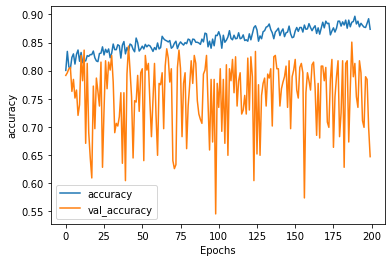

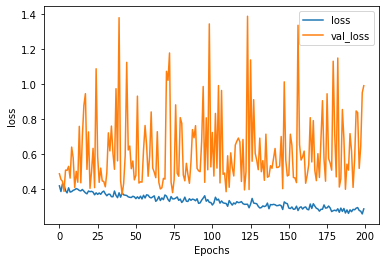

In [28]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [29]:
# delete the data

shutil.rmtree('/tmp/Liver_'+equipment)

In [ ]:
import os, signal
train_generator, test_generator
os.kill(os.getpid(),signal.SIGKILL)